In [1]:
# import functions from ../definitions/definitions_EDA
import sys
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
sys.path.append('../definitions')
import definitions_EDA as eda
# import definitions_plotting as def_plot
from pandas.plotting import autocorrelation_plot
import gc
import scipy as sp
from matplotlib.colors import LogNorm

RECORDS_PER_DAY = 431996

# Not Storm Processing

In [4]:
start_date = pd.Timestamp('2024-05-18')
end_date = pd.Timestamp('2024-07-10')
# List of specific dates
storm_dates = ['2024-05-11', '2024-05-10', '2024-08-12', '2024-05-12', '2024-03-24',
             '2024-08-13', '2024-04-19', '2024-08-04', '2024-03-03', '2024-06-28', 
             '2024-05-13', '2024-05-17', '2024-05-02', '2024-05-18', '2024-05-16', 
             '2024-03-25', '2024-03-04']
date_list = pd.to_datetime(storm_dates)

# this code iterates through each day between the start_date and end_date and runs all neccessary code to add a column called "flat" assign
#  its value to zero. Then resample the records (get the average of 60 records creating an new sampling frequency of 1 obsdervation
# every 12 seconds. The new df is then writen to the "NOT STORM" folder with the date as its name

for day in pd.date_range(start_date, end_date, freq='D'):
    if day not in date_list:
        start_date = day.date()
        end_date = day.date()
        df = eda.get_data(eda.read_txt_file, start_date, end_date)
        df = eda.calculate_h_component(df)
        df['flag'] = 0
        df = eda.calculate_mean_of_five_in_chunks(df)
        df.to_csv(f'/Users/tristan/Library/CloudStorage/OneDrive-StellenboschUniversity/Academics/Final_year/Semester 2/Skripsie/Data/NOT STORM/{start_date.strftime("%Y-%m-%d")}.csv')

# Storm Processing

Fetch data and store as dataframe (data ingestion)

Number of observations per day: 
 DateTime
2024-06-11    161998
2024-06-12    314397
2024-06-13    269999
2024-06-14    117600
Freq: D, dtype: int64
 
 Shape of dataframe (863994, 5)
 
Number of days data = Total records 863994 / records per day 431996 = 2.000004629672497 
 
Head of dataframe: 
                          NS_SQUID   Z_SQUID  NS_Fluxgate  EW_Fluxgate  Z_Fluxgate
DateTime                                                                         
2024-06-11 00:00:00.390  -32.3339 -170.0960   10949.4093     -87.2830 -22661.5116
2024-06-11 00:00:00.590  -32.3374 -170.1230   10949.4025     -87.3452 -22661.5130
2024-06-11 00:00:00.790  -32.3470 -170.1433   10949.4025     -87.3452 -22661.5130
2024-06-11 00:00:00.990  -32.3378 -170.1248   10949.3969     -87.3340 -22661.5152
2024-06-11 00:00:01.190  -32.3351 -170.1134   10949.4025     -87.3418 -22661.5035


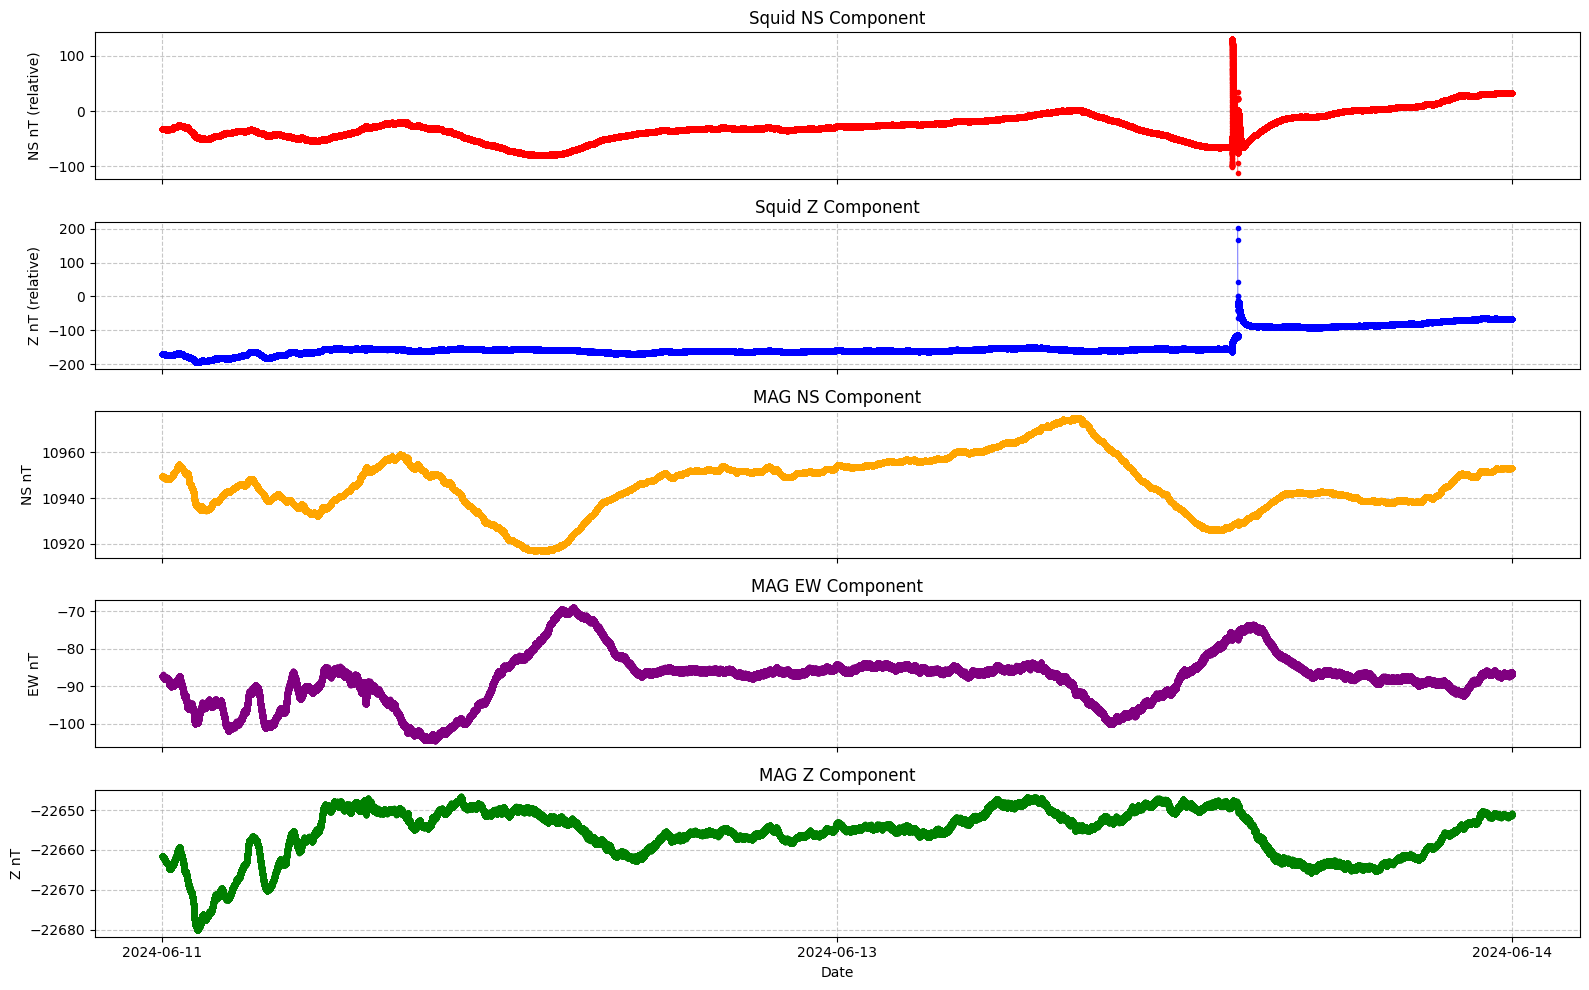

In [2]:
start_date = pd.Timestamp('2024-06-11')
end_date = pd.Timestamp('2024-06-12')
df = eda.get_data(eda.read_txt_file, start_date, end_date)
observations_per_day = df.resample('D').size()
#df = df.iloc[350000:863994, :] # Select some subset of data
# df = df.astype({'NS_SQUID': 'float32', 'Z_SQUID': 'float32', 'NS_Fluxgate': 'float32', 'EW_Fluxgate': 'float32', 'Z_Fluxgate': 'float32'})
print(f"Number of observations per day: \n",observations_per_day)
print(f' \n Shape of dataframe', df.shape)
print(f' \nNumber of days data = Total records {df.shape[0]} / records per day {RECORDS_PER_DAY} = {df.shape[0]/RECORDS_PER_DAY} ')
print(f' \nHead of dataframe: \n', df.head().to_string(index=True))
eda.generateDataPlots(df['NS_SQUID'].values, df['Z_SQUID'].values, df['NS_Fluxgate'].values, df['EW_Fluxgate'].values, df['Z_Fluxgate'].values, len(df), RECORDS_PER_DAY, start_date, end_date)

# Feature Generation

Now add the H component

In [3]:
corrected_df = eda.calculate_h_component(df)
observations_per_day = corrected_df.resample('D').size()
print(observations_per_day)

DateTime
2024-06-11    161998
2024-06-12    314397
2024-06-13    269999
2024-06-14    117600
Freq: D, dtype: int64


Identify the storm areas and mark with 1 in flag column

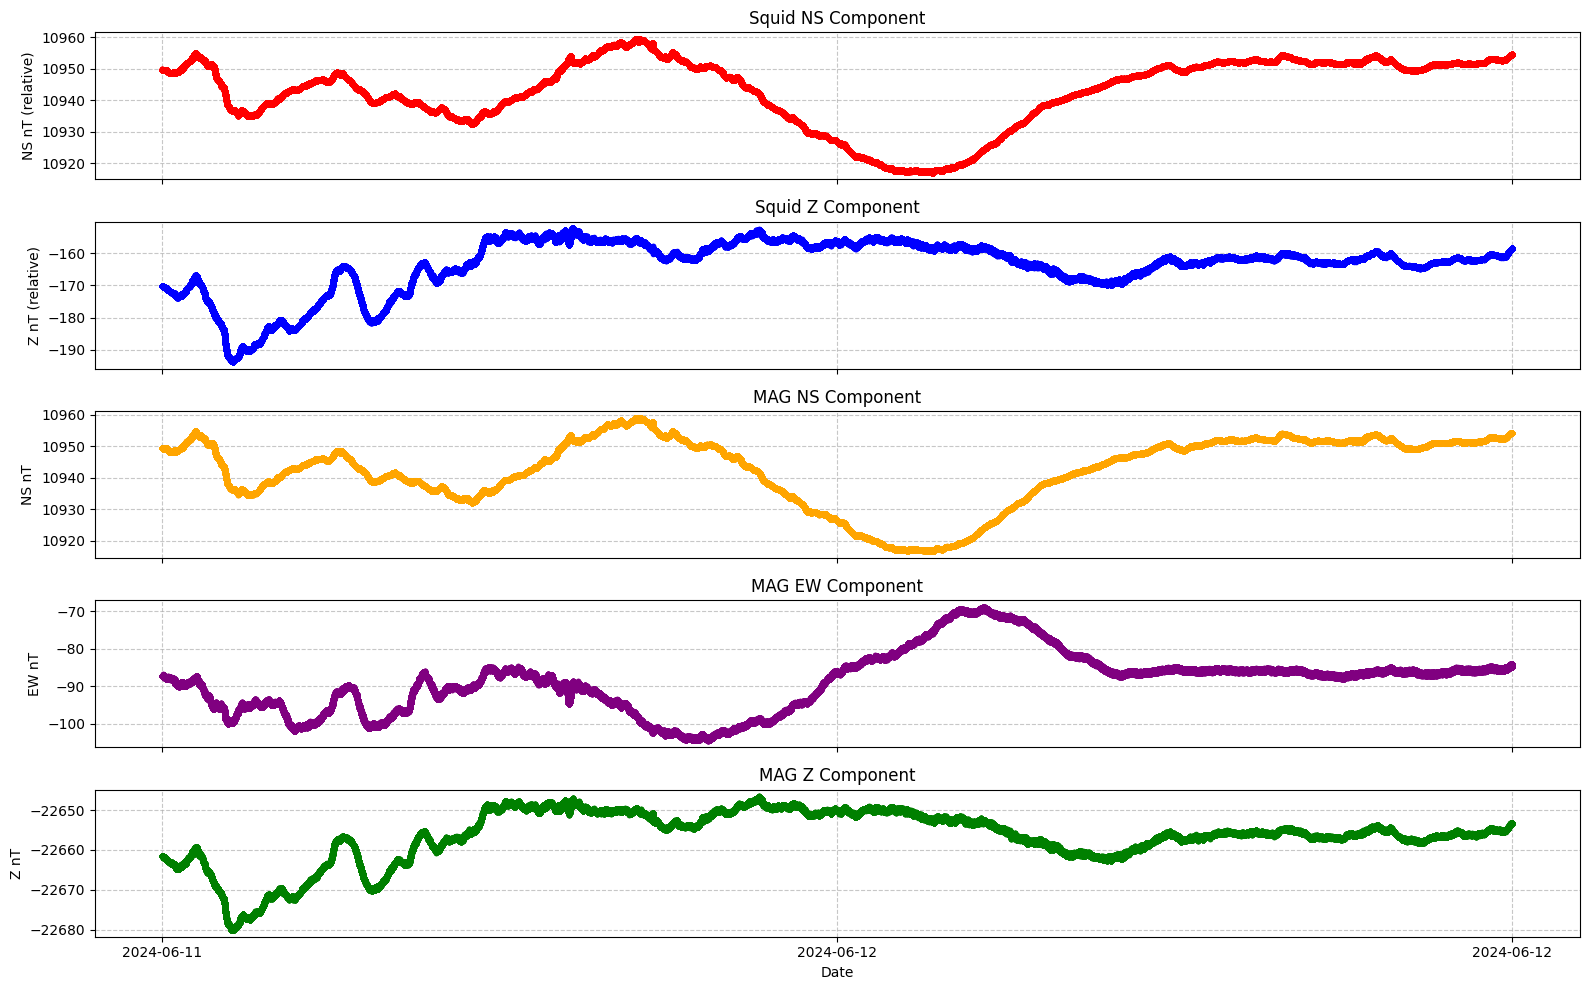

In [4]:
START = 0
END = 220000
test = df.iloc[START:RECORDS_PER_DAY, :] # Select some subset of data
eda.generateDataPlots(test['H Component'].values, test['Z_SQUID'].values, test['NS_Fluxgate'].values, test['EW_Fluxgate'].values, test['Z_Fluxgate'].values, len(test), RECORDS_PER_DAY, start_date, end_date)

In [5]:
# corrected_df['Date'] = pd.to_datetime(corrected_df.index.date)

corrected_df['flag'] = np.where((corrected_df.index >= corrected_df.index[START]) & (corrected_df.index <= corrected_df.index[END]), 1, 0)
# corrected_df['flag'] = corrected_df['Date'].isin(date_list).astype(int)
# corrected_df = corrected_df.drop('Date', axis=1)

print(corrected_df.head())
print(corrected_df.shape)
num_ones = corrected_df['flag'].sum()
print(f" Proportion of ones:",num_ones/len(corrected_df))

                         NS_SQUID   Z_SQUID  NS_Fluxgate  EW_Fluxgate  \
DateTime                                                                
2024-06-11 00:00:00.390  -32.3339 -170.0960   10949.4093     -87.2830   
2024-06-11 00:00:00.590  -32.3374 -170.1230   10949.4025     -87.3452   
2024-06-11 00:00:00.790  -32.3470 -170.1433   10949.4025     -87.3452   
2024-06-11 00:00:00.990  -32.3378 -170.1248   10949.3969     -87.3340   
2024-06-11 00:00:01.190  -32.3351 -170.1134   10949.4025     -87.3418   

                         Z_Fluxgate   H Component  flag  
DateTime                                                 
2024-06-11 00:00:00.390 -22661.5116  10949.757182     1  
2024-06-11 00:00:00.590 -22661.5130  10949.750878     1  
2024-06-11 00:00:00.790 -22661.5130  10949.750878     1  
2024-06-11 00:00:00.990 -22661.5152  10949.745189     1  
2024-06-11 00:00:01.190 -22661.5035  10949.750851     1  
(863994, 7)
 Proportion of ones: 0.3342638953511251


View the ones

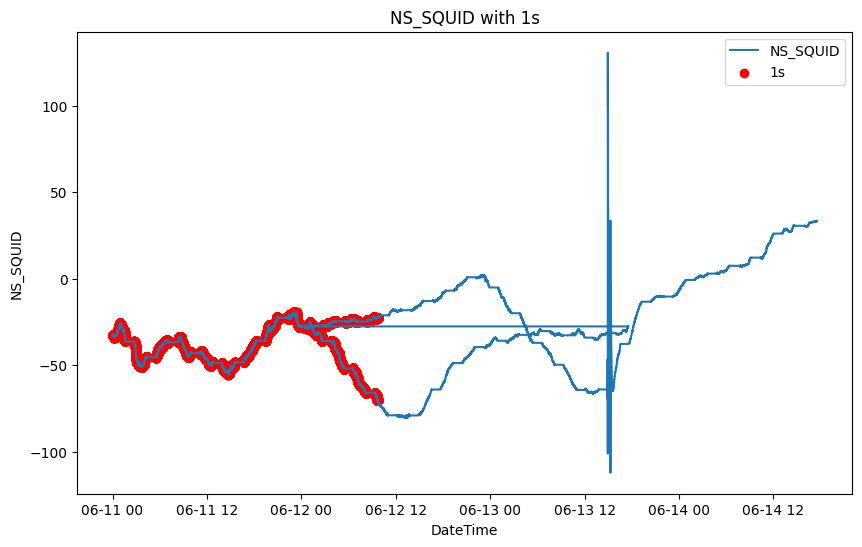

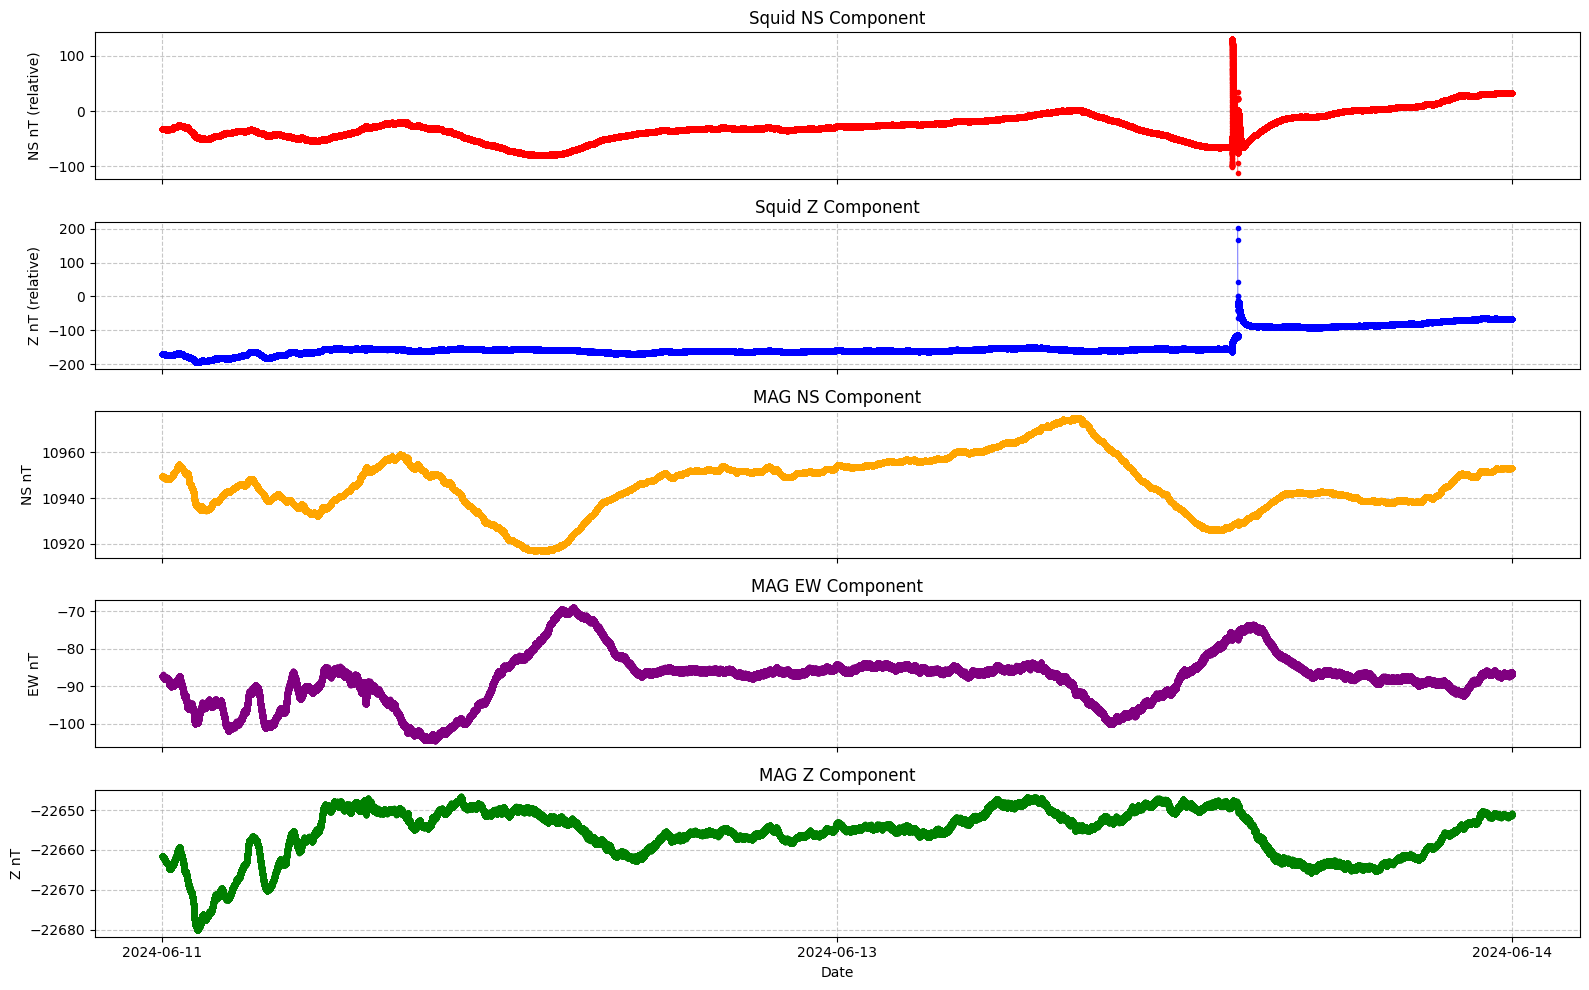

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(corrected_df['NS_SQUID'], label='NS_SQUID')
plt.scatter(corrected_df[corrected_df['flag'] == 1].index, corrected_df[corrected_df['flag'] == 1]['NS_SQUID'], color='red', label='1s')
plt.xlabel('DateTime')
plt.ylabel('NS_SQUID')
plt.title('NS_SQUID with 1s')
plt.legend()
plt.show()
eda.generateDataPlots(corrected_df['NS_SQUID'].values, corrected_df['Z_SQUID'].values, corrected_df['NS_Fluxgate'].values, corrected_df['EW_Fluxgate'].values, corrected_df['Z_Fluxgate'].values, len(corrected_df), RECORDS_PER_DAY, start_date, end_date)

Resample and save

In [ ]:
resampled_df = pd.DataFrame()
print(f"\nThis is the shape of the original data\n", corrected_df.shape)
resampled_data = eda.calculate_mean_of_five_in_chunks(corrected_df)
resampled_data.to_csv(f'/Users/tristan/Library/CloudStorage/OneDrive-StellenboschUniversity/Academics/Final_year/Semester 2/Skripsie/Data/STORM LABELLED/{start_date.strftime("%Y-%m-%d")}.csv')

print(f"\nThis is the shape of the resampled data\n", resampled_data.shape)
print(f"\nThis is the new resampled dataframe\n", resampled_data.head())
#eda.generateDataPlots(resampled_df['NS_SQUID'].values, resampled_df['Z_SQUID'].values, resampled_df['NS_Fluxgate'].values, resampled_df['EW_Fluxgate'].values, resampled_df['Z_Fluxgate'].values, len(resampled_df), RECORDS_PER_DAY, start_date, end_date)


# Scale SQUID data

Determine the Offset (Baseline)

Define Quiet Period

In [11]:
# start_date_quiet = '2024-03-26'
# end_date_quiet = '2024-03-31'

# data_arr_mag = eda.process_data(eda.get_data('ctumag', eda.read_txt_file, start_date_quiet, end_date_quiet))
# data_arr_squid = eda.process_data(eda.get_data('squid', eda.read_txt_file, start_date_quiet, end_date_quiet))
# df_quiet = eda.create_dataframe(data_arr_mag, data_arr_squid, start_date_quiet)
# df_quiet = df_quiet.astype({'NS_SQUID': 'float32', 'Z_SQUID': 'float32', 'NS_Fluxgate': 'float32', 'EW_Fluxgate': 'float32', 'Z_Fluxgate': 'float32'})
# del data_arr_mag, data_arr_squid
# gc.collect()
# # df = df.between_time('12:30:00', '13:30:00') # Select only a small subset of the data for analysis
# # print(f' \n Shape of df', df.shape)
# print(f' \nNumber of days data = Total records {df_quiet.shape[0]} / records per day (431998) = {df_quiet.shape[0]/431998} ')
# print(f' \nHead of dataframe: \n', df_quiet.head().to_string(index=True))


Calculate offset

In [12]:
# columns  = ["NS_SQUID","Z_SQUID"]
# for column in df_quiet.columns:
#     feature_mean = df_quiet[column].mean()


# Standardise the dataset

Using Z-Score

In [13]:
# for column in df.columns:
#     df[column] = (df[column] - df[column].mean()) / df[column].std()

# print(f'New head after standardize\n', df.head())
# print(f"Shape after normalisation", df.shape)
# eda.generateDataPlots(df['NS_SQUID'].values, df['Z_SQUID'].values, df['NS_Fluxgate'].values, df['EW_Fluxgate'].values, df['Z_Fluxgate'].values, len(df), RECORDS_PER_DAY, start_date, end_date)

### Check for missing values and zero values

In [ ]:
for column in df.columns:
    print(f"\n Number of missing values in {column} is: ", df[column].isna().sum())
    print(f"Nmber of zeros in {column} is: ", (df[column] == 0).sum())

### Outlier Test

Z score test

In [15]:
# print(f' \n Shape of df before removing outliers', df.shape)
# outliers_removed_z = eda.z_score_test(df)
# print(f"Head of outliers removed dataframe:\n", outliers_removed_z.head())
# print(f' \n Shape of df after removing outliers', outliers_removed_z.shape)
# print(f'\nProportion of data removed:', (1-outliers_removed_z.shape[0]/df.shape[0])*100, '%')
# del df
# gc.collect()
# observations_per_day = outliers_removed_z.resample('D').size()
# print(observations_per_day)
# eda.generateDataPlots(outliers_removed_z['NS_SQUID'].values, outliers_removed_z['Z_SQUID'].values, outliers_removed_z['NS_Fluxgate'].values, outliers_removed_z['EW_Fluxgate'].values, outliers_removed_z['Z_Fluxgate'].values,len(outliers_removed_z), RECORDS_PER_DAY, start_date, end_date)

### Fix sudden jumps or drops in the data

As we can see there are severe drops in the squid data. Lets fix these

In [16]:
# corrected_df_ns = eda.detect_spikes_and_correct(outliers_removed_z, "NS_SQUID")
# corrected_df_f = eda.detect_spikes_and_correct(corrected_df_ns, "Z_SQUID")
# corrected_df_nf = eda.detect_spikes_and_correct(corrected_df_f, "NS_Fluxgate")
# corrected_df_ew = eda.detect_spikes_and_correct(corrected_df_nf, "EW_Fluxgate")
# corrected_df = eda.detect_spikes_and_correct(corrected_df_ew, "Z_Fluxgate")
# del outliers_removed_z, corrected_df_ns, corrected_df_f, corrected_df_nf, corrected_df_ew
# gc.collect()
# eda.generateDataPlots(corrected_df['NS_SQUID'].values, corrected_df['Z_SQUID'].values, corrected_df['NS_Fluxgate'].values, corrected_df['EW_Fluxgate'].values, corrected_df['Z_Fluxgate'].values, len(corrected_df), RECORDS_PER_DAY, start_date, end_date)

Test for stationarity

In [17]:
eda.perform_dickey_fuller_test(resampled_df)

Test for seasonality and trend

In [ ]:
eda.test_stationarity(corrected_df)

Now using the autocorrelation_plot

In [19]:
# Draw Plot
for column in resampled_df.columns:
    plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
    autocorrelation_plot(resampled_df[column].tolist())
    plt.title(f'Autocorrelation for {column}')
    plt.show()  # Display the plot

Fourier Transform

In [ ]:
components, fourier_results = eda.calculate_fourier_transforms(df)
eda.plot_fourier_transform(fourier_results, components)

Create PDF of each feature

In [ ]:
import seaborn as sns

for column in resampled_df.columns:
    sns.displot(resampled_df[column], kde=True)

Perform Decomposition

In [ ]:
# Additive Decomposition
# result_add = seasonal_decompose(df['Z_Fluxgate'], model='additive', extrapolate_trend='freq')

# Plot
# plt.rcParams.update({'figure.figsize': (10,10)})
# result_add.plot().suptitle('Additive Decompose', fontsize=22)
# plt.show()

Waterfall plots

In [ ]:
# Assume you have a signal 'sig' sampled at regular intervals ('time_step')
sig = resampled_data["H Component"].to_numpy()
sig_fft = sp.fft.fft(sig)
power = np.abs(sig_fft) ** 2
sample_freq = sp.fft.fftfreq(sig.size, d=1)

# Plot the FFT power
plt.figure(figsize=(6, 5))
plt.plot(sample_freq, power)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")

# Find the peak frequency
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

# An inner plot to show the peak frequency
axes = plt.axes([0.55, 0.3, 0.3, 0.5])
plt.title("Peak frequency")
plt.plot(freqs[:8], power[pos_mask][:8])
plt.setp(axes, yticks=[])


In [ ]:
print(resampled_df)
# Function to plot waterfall FFT for each component
def plot_waterfall(df, fs=1/60):
    nfft = 256  # Length of each segment
    noverlap = 128  # Overlap between segments

    for column in df.columns:
        signal = df[column].values
        plt.figure()
        plt.specgram(signal, NFFT=nfft, Fs=fs, noverlap=noverlap, cmap='viridis',norm=LogNorm())
        plt.title(f'Waterfall FFT Plot for {column}')
        plt.xlabel('Time [s]')
        plt.ylabel('Frequency [Hz]')
        plt.colorbar(label='Intensity [dB]')
        plt.show()

# Plot the waterfall FFT for each component
plot_waterfall(resampled_df)